In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [77]:
df = pd.read_csv('bus_1_load_copy.csv')
start_date = '01-01-2018'
datetime_index = pd.date_range(start=start_date, periods=len(df), freq='h')
df.index = datetime_index

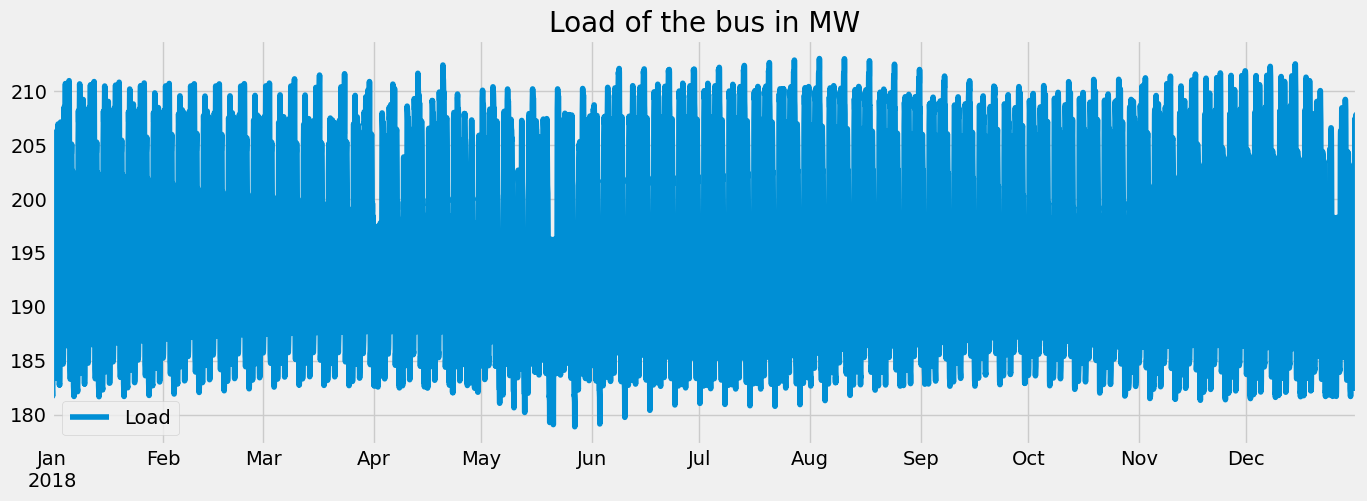

In [78]:
df.plot(style='-', 
        figsize=(15, 5), 
        color=color_pal[0], 
        title='Load of the bus in MW')
plt.show()

<Axes: ylabel='Frequency'>

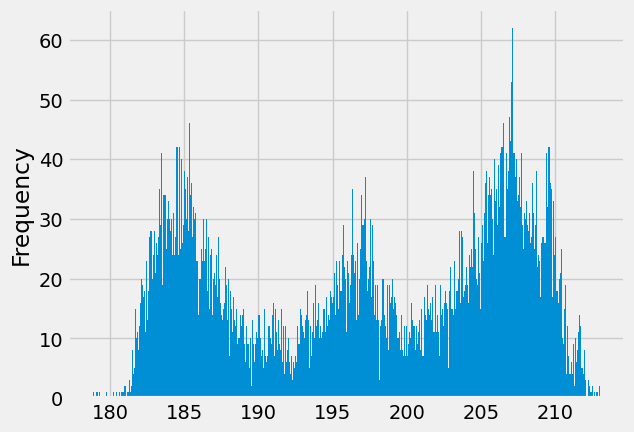

In [79]:
# Outlier Analysis and removal

df['Load'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}>

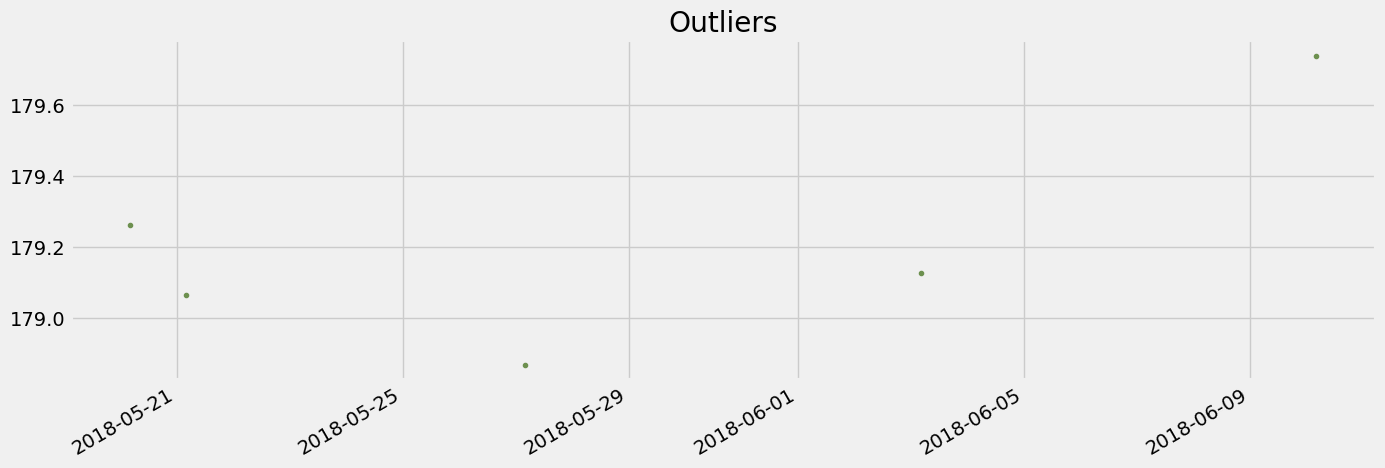

In [80]:
# Analyze the outliers
df.query('Load < 180')['Load'].plot(style='.',
          figsize=(15, 5),
          color=color_pal[3],
          title='Outliers')

# This would filter the outliers below 180 away
# df = df.query('Load > 180').copy()

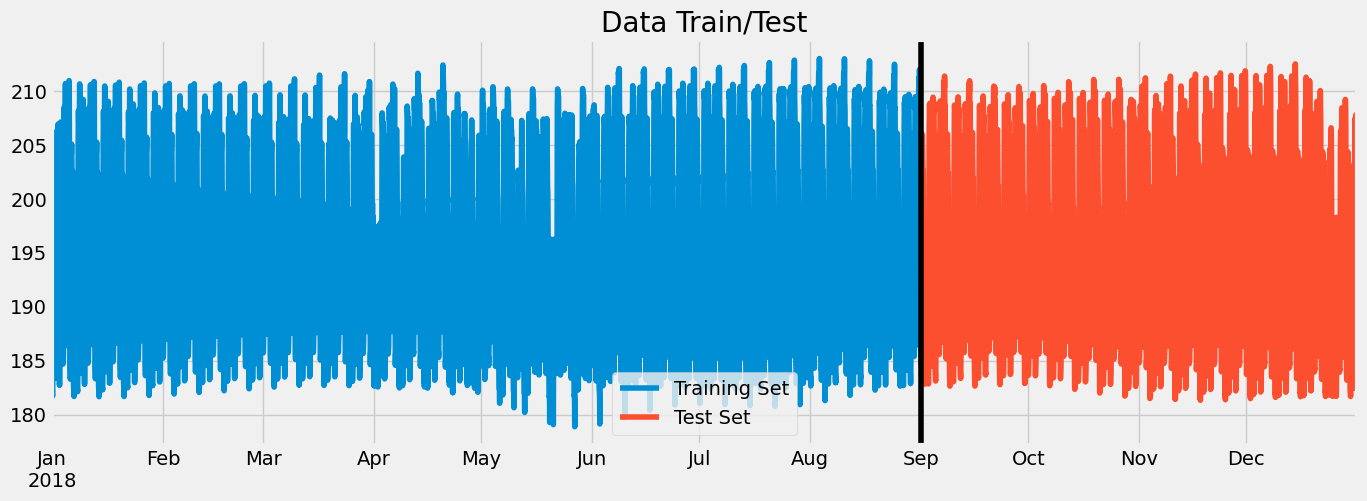

In [81]:
# Review train/test split
train = df.loc[df.index < '09-01-2018']     # Month-day-year
test = df.loc[df.index >= '09-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test')
test.plot(ax=ax, label='Test Set')
ax.axvline('09-01-2018', color='black', ls='-')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [82]:
# Time Series Cross Validation, import new library
tss = TimeSeriesSplit(n_splits=5, test_size=24*60, gap=24)      # declare test size
df = df.sort_index()

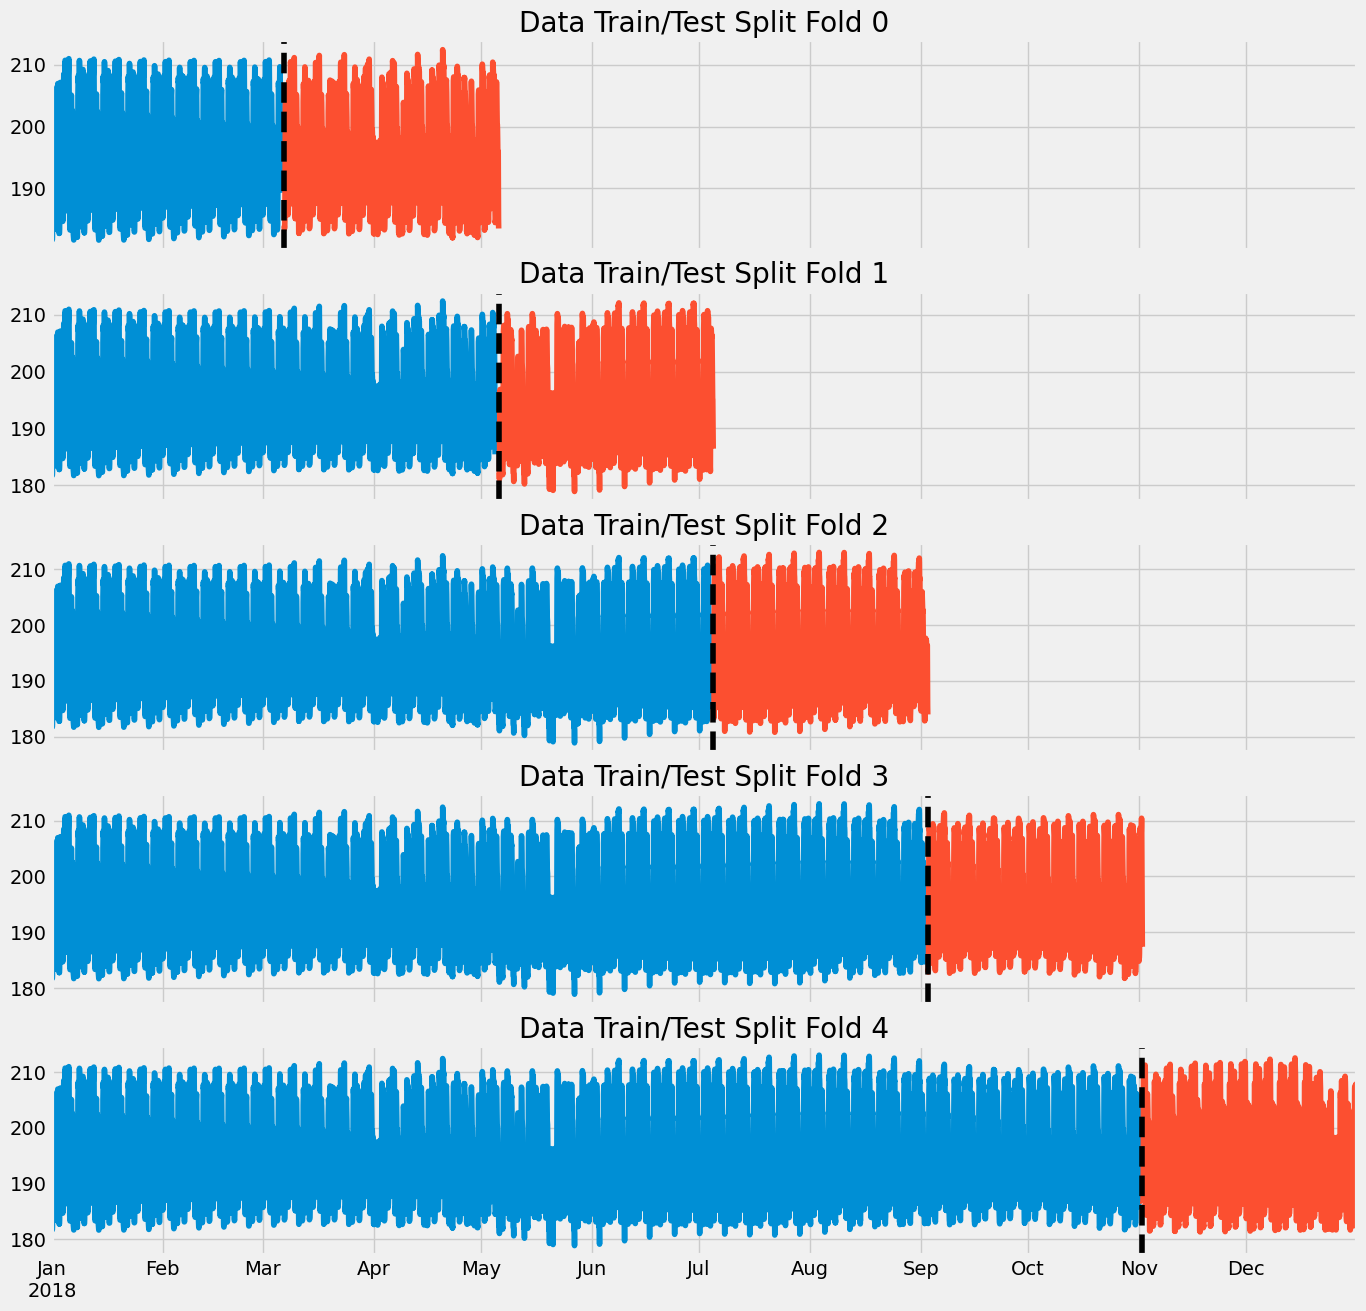

In [83]:

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Load'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Load'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# train_idx
# val_idx

In [84]:
# Forecasting Horizon
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week      # Not working
    return df

df = create_features(df)
# df

In [85]:
# Lag features
def add_lags(df):
    target_map = df['Load'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    return df

In [86]:
df = add_lags(df)

In [87]:
# Train using Cross Validation
tss = TimeSeriesSplit(n_splits=5, test_size=2*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Load'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',              # Need to change
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:195.00441	validation_1-rmse:195.59904
[100]	validation_0-rmse:71.47667	validation_1-rmse:71.93167


c:\Users\bodhi\miniconda3\envs\bap_project\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:22:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:26.26981	validation_1-rmse:26.46504
[300]	validation_0-rmse:9.79805	validation_1-rmse:9.79975
[400]	validation_0-rmse:3.97330	validation_1-rmse:3.69471
[500]	validation_0-rmse:2.18011	validation_1-rmse:1.48739
[600]	validation_0-rmse:1.73232	validation_1-rmse:0.74762
[700]	validation_0-rmse:1.61837	validation_1-rmse:0.55984
[800]	validation_0-rmse:1.52347	validation_1-rmse:0.52224
[900]	validation_0-rmse:1.41634	validation_1-rmse:0.51165
[999]	validation_0-rmse:1.33230	validation_1-rmse:0.50494
[0]	validation_0-rmse:195.06319	validation_1-rmse:195.35907
[100]	validation_0-rmse:71.48903	validation_1-rmse:71.56307


c:\Users\bodhi\miniconda3\envs\bap_project\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:22:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:26.26302	validation_1-rmse:26.21736
[300]	validation_0-rmse:9.77588	validation_1-rmse:9.62428
[400]	validation_0-rmse:3.92483	validation_1-rmse:3.56252
[500]	validation_0-rmse:2.10471	validation_1-rmse:1.40778
[600]	validation_0-rmse:1.65135	validation_1-rmse:0.72079
[700]	validation_0-rmse:1.53477	validation_1-rmse:0.57216
[800]	validation_0-rmse:1.46527	validation_1-rmse:0.54725
[900]	validation_0-rmse:1.37342	validation_1-rmse:0.53817
[999]	validation_0-rmse:1.27560	validation_1-rmse:0.53857
[0]	validation_0-rmse:195.10660	validation_1-rmse:195.41618
[100]	validation_0-rmse:71.49721	validation_1-rmse:71.60443


c:\Users\bodhi\miniconda3\envs\bap_project\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:26.25693	validation_1-rmse:26.26810
[300]	validation_0-rmse:9.75822	validation_1-rmse:9.68109
[400]	validation_0-rmse:3.88817	validation_1-rmse:3.69625
[500]	validation_0-rmse:2.04726	validation_1-rmse:1.71143
[600]	validation_0-rmse:1.58290	validation_1-rmse:1.22301
[700]	validation_0-rmse:1.46713	validation_1-rmse:1.14043
[800]	validation_0-rmse:1.39601	validation_1-rmse:1.12648
[900]	validation_0-rmse:1.31086	validation_1-rmse:1.12381
[999]	validation_0-rmse:1.22180	validation_1-rmse:1.11694
[0]	validation_0-rmse:195.13975	validation_1-rmse:195.71822
[100]	validation_0-rmse:71.50344	validation_1-rmse:71.69113


c:\Users\bodhi\miniconda3\envs\bap_project\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:26.25303	validation_1-rmse:26.28059
[300]	validation_0-rmse:9.74783	validation_1-rmse:9.68724
[400]	validation_0-rmse:3.86731	validation_1-rmse:3.68494
[500]	validation_0-rmse:2.00969	validation_1-rmse:1.59725
[600]	validation_0-rmse:1.54327	validation_1-rmse:1.13021
[700]	validation_0-rmse:1.42089	validation_1-rmse:1.08597
[720]	validation_0-rmse:1.40156	validation_1-rmse:1.09643
[0]	validation_0-rmse:195.18722	validation_1-rmse:194.58021
[100]	validation_0-rmse:71.51605	validation_1-rmse:70.81060


c:\Users\bodhi\miniconda3\envs\bap_project\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:22:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:26.25269	validation_1-rmse:25.59842
[300]	validation_0-rmse:9.74049	validation_1-rmse:9.19193
[400]	validation_0-rmse:3.84971	validation_1-rmse:3.49783
[500]	validation_0-rmse:1.98404	validation_1-rmse:2.04785
[600]	validation_0-rmse:1.51972	validation_1-rmse:1.91348
[634]	validation_0-rmse:1.46500	validation_1-rmse:1.92434


In [88]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1.0299
Fold scores:[0.5046385685200961, 0.5371063797188018, 1.1169368048081447, 1.0785482335790098, 1.9120654964103683]


In [89]:
# Predicting the future
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Load'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:195.14199
[100]	validation_0-rmse:71.49694


c:\Users\bodhi\miniconda3\envs\bap_project\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:26.24505
[300]	validation_0-rmse:9.73978
[400]	validation_0-rmse:3.85810
[499]	validation_0-rmse:2.01308


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [90]:
df.index.max()

Timestamp('2018-12-31 23:00:00')

In [103]:
# Create future dataframe, give predictions for 2019
future = pd.date_range('01-01-2019','01-08-2019', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])      # combination of both old and future data
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [104]:
future_w_features = df_and_future.query('isFuture').copy()      # Extract future data with features. We don't know the actual data of these future values

In [105]:
# Predict the future
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

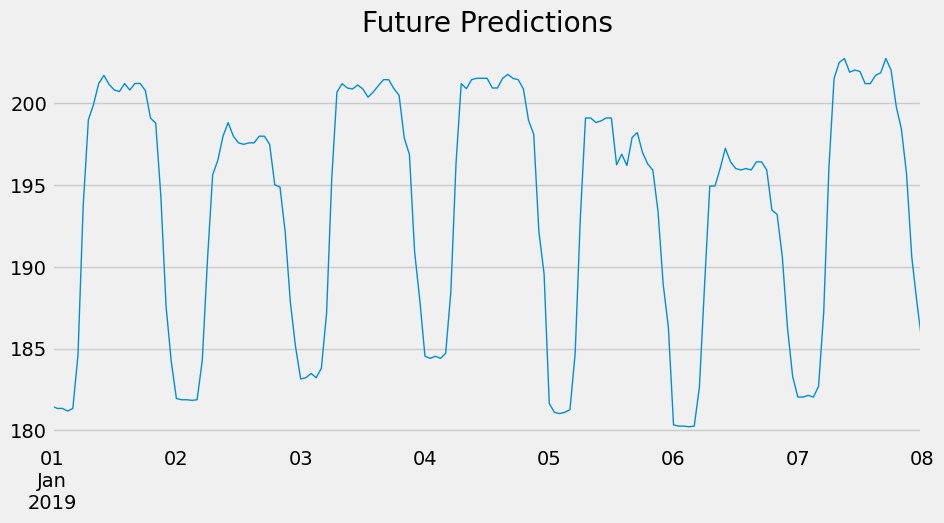

In [106]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[0],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()